In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import os
# Load required libraries
import matplotlib.pyplot as plt
import time
import pickle
import seaborn as sns
import sys
sys.setrecursionlimit(1500)
%matplotlib inline

In [2]:
NEWLINE = '\n'

HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('dataSets/nw/ham',      HAM),
    ('dataSets/nw/spam',     SPAM)
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = True, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = pd.DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = pd.DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(np.random.permutation(data.index))
    return data

In [3]:
# We will load the Email spam dataset into Panadas dataframe here . 
data=load_data()

In [4]:
data = data.sample(frac=1).reset_index(drop=True)
print(len(data))
print(data)

7495
                                                   text class
0     Subject: 8 th noms\n\n- - - - - - - - - - - - ...   ham
1     Subject: save your money by getting an oem sof...  spam
2     Subject: visual identity and logo now\n\nworki...  spam
3     Subject: financial freedom\n\ndear friend ,\n\...  spam
4     Subject: re : sales to panenergy at exxon clea...   ham
...                                                 ...   ...
7490  Subject: fre @ backgammon\n\nisrael approved p...  spam
7491  Subject: gmt . inc .\n\ntom ,\n\nplease create...   ham
7492  Subject: seagate 20 / 40 gb dat tape drive ( i...  spam
7493                                        Subject: \n  spam
7494  Subject: re : executive program on credit risk...   ham

[7495 rows x 2 columns]


In [5]:
f = lambda x: ' '.join([item for item in x.split() if item not in ["Subject","Subject:","subject"]])
data["text"] = data["text"].apply(f)

In [6]:
# We change the dataframe index from filenames to indices here. 
new_index=[x for x in range(len(data))]
data.index=new_index

In [7]:
print(data)

                                                   text class
0     8 th noms - - - - - - - - - - - - - - - - - - ...   ham
1     save your money by getting an oem software ! n...  spam
2     visual identity and logo now working on your c...  spam
3     financial freedom dear friend , how would you ...  spam
4     re : sales to panenergy at exxon clear lake fo...   ham
...                                                 ...   ...
7490  fre @ backgammon israel approved plans this we...  spam
7491  gmt . inc . tom , please create a spot ticket ...   ham
7492  seagate 20 / 40 gb dat tape drive ( internal )...  spam
7493                                                     spam
7494  re : executive program on credit risk vince , ...   ham

[7495 rows x 2 columns]


In [8]:
# We will load the Email spam dataset into Panadas dataframe here . 
SOURCES = [
    ('dataSets/nw/testSet',      HAM)
]
test_data=load_data()

In [9]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [10]:
#We will add two more columns to our dataframe for tokenized text and token count.
def token_count(row):
    'returns token count'
    text=row['tokenized_text']
    length=len(text.split())
    return length

def tokenize(row):
    "tokenize the text using default space tokenizer"
    text=row['text']
    lines=(line for line in text.split(NEWLINE) )
    tokenized=""
    for sentence in lines:
        tokenized+= " ".join(tok for tok in sentence.split())
    return tokenized

In [11]:
#We will use apply functions on dataframe to add the columns for :

#* Tokenized text
#* Token Count
#* Language
#Language column in this case is not necessary as we only have english text. However this approach 
# is good for properly dealing with multi lingual data.



data['tokenized_text']=data.apply(tokenize, axis=1)
data['token_count']=data.apply(token_count, axis=1)
# Checking the data
data.head()

,text,class,tokenized_text,token_count
0,8 th noms - - - - - - - - - - - - - - - - - - ...,ham,8 th noms - - - - - - - - - - - - - - - - - - ...,120
1,save your money by getting an oem software ! n...,spam,save your money by getting an oem software ! n...,34
2,visual identity and logo now working on your c...,spam,visual identity and logo now working on your c...,208
3,"financial freedom dear friend , how would you ...",spam,"financial freedom dear friend , how would you ...",187
4,re : sales to panenergy at exxon clear lake fo...,ham,re : sales to panenergy at exxon clear lake fo...,1375


In [12]:
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [13]:
from nltk.stem import *

In [14]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [15]:
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [16]:
data.head()

,text,class,tokenized_text,token_count
0,8 th noms - - - - - - - - - - - - - - - - - - ...,ham,8 th nom - - - - - - - - - - - - - - - - - - -...,120
1,save your money by getting an oem software ! n...,spam,save money get oem softwar ! need softwar pc ?...,34
2,visual identity and logo now working on your c...,spam,visual ident logo work compani ' imag ? start ...,208
3,"financial freedom dear friend , how would you ...",spam,"financi freedom dear friend , would like make ...",187
4,re : sales to panenergy at exxon clear lake fo...,ham,: sale panenergi exxon clear lake 2 / 99 anita...,1375


In [17]:
import nltk
# nltk.download('wordnet')

In [18]:
from nltk.stem.wordnet import WordNetLemmatizer

In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
# test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

In [21]:
data.head()

,text,class,tokenized_text,token_count
0,8 th noms - - - - - - - - - - - - - - - - - - ...,ham,8 th nom - - - - - - - - - - - - - - - - - - -...,120
1,save your money by getting an oem software ! n...,spam,save money get oem softwar ! need softwar pc ?...,34
2,visual identity and logo now working on your c...,spam,visual ident logo work compani ' imag ? start ...,208
3,"financial freedom dear friend , how would you ...",spam,"financi freedom dear friend , would like make ...",187
4,re : sales to panenergy at exxon clear lake fo...,ham,: sale panenergi exxon clear lake 2 / 99 anita...,1375


In [22]:
# Lets look at some information related to the data
df=data
print("total emails : ", len(df))
print  ("total spam emails : ", len(df[df['class']=='spam']) )
print  ("total normal emails : ", len(df[df['class']=='ham']) )

total emails :  7495
total spam emails :  4499
total normal emails :  2996


Text(0.5, 1.0, 'Plot of Emails count with languages and email type')

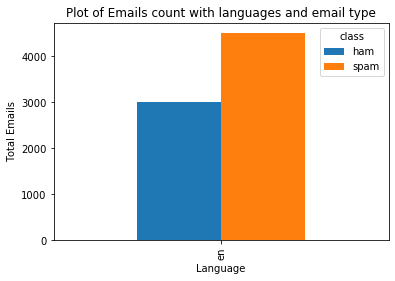

In [23]:
data['lang']='en'
df1 = df.groupby(['lang','class'])['class','lang'].size().unstack()

ax=df1.plot(kind='bar')
ax.set_ylabel("Total Emails")
ax.set_xlabel("Language")
ax.set_title("Plot of Emails count with languages and email type")

In [24]:
# We randomize the rows to subset the dataframe
df.reset_index(inplace=True)
df=df.reindex(np.random.permutation(df.index))

In [25]:
df.head()

,index,text,class,tokenized_text,token_count,lang
395,395,aggressive investors and traders shouid be wat...,spam,"aggress investor trader shouid watch "" stock w...",620,en
391,391,off - site : john griebling ' s organization a...,ham,- site : john griebl ' organ research group je...,254,en
647,647,to valentin ' s shop customers ! dear customer...,spam,valentin ' shop custom ! dear custom ! updat s...,49,en
1783,1783,3 / 4 / 2000 and following noms hpl can ' t ta...,ham,3 / 4 / 2000 follow nom hpl ' take extra 15 mm...,303,en
5358,5358,purchase of license for software hello all ! p...,ham,purchas licens softwar hello ! plea order visu...,98,en


In [26]:
len_unseen = 1000
df_unseen_test= df.iloc[:len_unseen]
df_model = df.iloc[len_unseen:]

print('total emails for unseen test data : ', len(df_unseen_test))
print('\t total spam emails for enron  : ', len(df_unseen_test[(df_unseen_test['lang']=='en') & (df_unseen_test['class']=='spam')]))
print('\t total normal emails for enron  : ', len(df_unseen_test[(df_unseen_test['lang']=='en') & (df_unseen_test['class']=='ham')]))
print()

print('total emails for model training/validation : ', len(df_model))
print('\t total spam emails for enron  : ', len(df_model[(df_model['lang']=='en') & (df_model['class']=='spam')]))
print('\t total normal emails for enron  : ', len(df_model[(df_model['lang']=='en') & (df_model['class']=='ham')]))

total emails for unseen test data :  1000
	 total spam emails for enron  :  601
	 total normal emails for enron  :  399

total emails for model training/validation :  6495
	 total spam emails for enron  :  3898
	 total normal emails for enron  :  2597


Text(0.5, 1.0, 'Token length Vs Frequency for Enron Spam Emails')

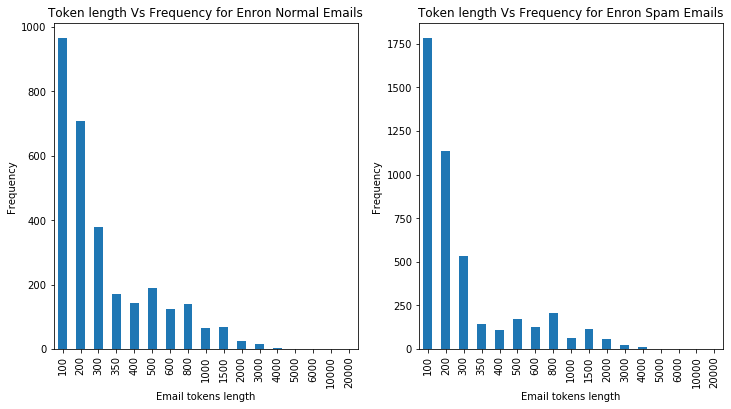

In [27]:
# Load required libraries
import matplotlib.pyplot as plt
bins = [0,100,200,300,350,400,500,600,800,1000,1500,2000,3000,4000,5000,6000,10000,20000]


fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
fig.subplots_adjust(hspace=.5)

df_sub=df[ (df['lang']=='en') & (df['class']=='ham')]
df1 = df_sub.groupby(pd.cut(df_sub['token_count'], bins=bins)).token_count.count()
df1.index=[a.right for a in df1.index]
res1=df1.plot(kind='bar',ax=axes[0])
res1.set_xlabel('Email tokens length')
res1.set_ylabel('Frequency')
res1.set_title('Token length Vs Frequency for Enron Normal Emails')


df_sub=df[ (df['lang']=='en') & (df['class']=='spam')]
df1 = df_sub.groupby(pd.cut(df_sub['token_count'], bins=bins)).token_count.count()
df1.index=[a.right for a in df1.index]
res2=df1.plot(kind='bar',ax=axes[1])
res2.set_xlabel('Email tokens length')
res2.set_ylabel('Frequency')
res2.set_title('Token length Vs Frequency for Enron Spam Emails')

In [28]:
import keras

from keras.layers import Input, Dense
from keras.models import Model,load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [29]:
import sklearn
from sklearn import metrics
from sklearn import svm
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder

C:\Users\pjalp\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [30]:
# max number of features
num_max = 4000

In [31]:
import time

def train_tf_idf_model(texts):
    "train tf idf model "
    tic = time.process_time()
    
    tok = Tokenizer(num_words=num_max)
    tok.fit_on_texts(texts)
    toc = time.process_time()

    print (" -----total Computation time = " + str((toc - tic)) + " seconds")
    return tok

def prepare_model_input(tfidf_model,dataframe,mode='tfidf'):
    
    "function to prepare data input features using tfidf model"
    tic = time.process_time()
    le = LabelEncoder()
    sample_texts = list(dataframe['tokenized_text'])
    sample_texts = [' '.join(x.split()) for x in sample_texts]
    
    targets=list(dataframe['class'])
    targets = [1. if x=='spam' else 0. for x in targets]
    sample_target = le.fit_transform(targets)
    
    if mode=='tfidf':
        sample_texts=tfidf_model.texts_to_matrix(sample_texts,mode='tfidf')
    else:
        sample_texts=tfidf_model.texts_to_matrix(sample_texts)
    
    toc = time.process_time()
    
    print('shape of Class: ', sample_target.shape)
    print('shape of data: ', sample_texts.shape)
    
    print (" -----total Computation time for preparing model data = " + str((toc - tic)) + " seconds")
    
    return sample_texts,sample_target

In [32]:
texts=list(df_model['tokenized_text'])
tfidf_model=train_tf_idf_model(texts)

 -----total Computation time = 1.0 seconds


In [33]:
# prepare model input data
mat_texts,tags=prepare_model_input(tfidf_model,df_model,mode='tfidf')

shape of Class:  (6495,)
shape of data:  (6495, 4000)
 -----total Computation time for preparing model data = 2.640625 seconds


In [34]:
#Splitting Training and Testing Data

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(mat_texts, tags, test_size=0.40)
print ('train data shape: ', X_train.shape, y_train.shape)
print ('validation data shape :' , X_val.shape, y_val.shape)

train data shape:  (3897, 4000) (3897,)
validation data shape : (2598, 4000) (2598,)


In [35]:
## Define and initialize the network

model_save_path="checkpoints/spam_detector_enron_model.h5"

In [36]:
import datetime
def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',keras.metrics.binary_accuracy])
    print('compile done')
    return model

def check_model(model,x,y,epochs=2):
    history=model.fit(x,y,batch_size=32,epochs=epochs,verbose=1,shuffle=True,validation_split=0.2,
              callbacks=[checkpointer, tensorboard]).history
    return history


def check_model2(model,x_train,y_train,x_val,y_val,epochs=10):
    history=model.fit(x_train,y_train,batch_size=64,
                      epochs=epochs,verbose=1,
                      shuffle=True,
                      validation_data=(x_val, y_val)).history
    return history

# define checkpointer
checkpointer = ModelCheckpoint(filepath=model_save_path,
                               verbose=1,
                               save_best_only=True)    


# define tensorboard
tensorboard = TensorBoard(log_dir = os.path.join("logs","fit",datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)




# define the predict function for the deep learning model for later use
def predict(data):
    result=model.predict(data)
    prediction = [round(x[0]) for x in result]
    return prediction

In [37]:
# get the compiled model
model = get_simple_model()

# load history
# history=check_model(m,mat_texts,tags,epochs=10)
history=check_model2(model,X_train,y_train,X_val,y_val,epochs=10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2048512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,180,097
Trainable params: 2,180,097
Non-trainable params: 0
_________________________________________________________________
compile done
Train on 3897 samples, validate on 2598 samples
Epoch 1/10
3897/3897 [===========================

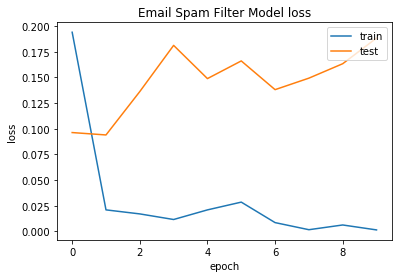

In [38]:
# plot the loss on train and validation data
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [39]:
##RANDOM FOREST MODEL


In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
spam_model_rf = RandomForestClassifier(n_estimators=1000,random_state=5)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
spam_model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [42]:
##EVALUATE MODEL PERFORMANCE

In [43]:
sample_texts,sample_target=prepare_model_input(tfidf_model,df_unseen_test,mode='')

shape of Class:  (1000,)
shape of data:  (1000, 4000)
 -----total Computation time for preparing model data = 0.21875 seconds


In [44]:
model_dict={}
model_dict['random_forest']=spam_model_rf
model_dict['neural_networks']=model

In [45]:

def getResults(model_dict,sample_texts,sample_target):
    '''
    Get results from different models
    '''
    results=[]
    
    results_cm={}
    
    for name,model in model_dict.items():
#         print(name)
        tic1 = time.process_time()
        if name in 'neural_networks':
            predicted_sample = predict(sample_texts)
            cm=sklearn.metrics.confusion_matrix(sample_target, predicted_sample)
        else:    
            predicted_sample = model.predict(sample_texts)
            cm=sklearn.metrics.confusion_matrix(sample_target, predicted_sample.round())
            
        toc1 = time.process_time()
#         print(predicted_sample)

        
        results_cm[name]=cm
        
        total=len(predicted_sample)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        
        time_taken=round(toc1 - tic1,4)
        res=sklearn.metrics.precision_recall_fscore_support(sample_target, predicted_sample)
        accuracy=sklearn.metrics.accuracy_score(sample_target, predicted_sample)
        results.append([name,np.mean(res[0]),np.mean(res[1]),np.mean(res[2]),accuracy,TP,FP,FN,TN,str(time_taken)] )
        
    
    df_cols=['model','precision','recall','f1_score','Accuracy','TP','FP','FN','TN','execution_time']
    result_df=pd.DataFrame(results,columns=df_cols)
    
    return result_df,results_cm
    

In [46]:
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

,model,precision,recall,f1_score,Accuracy,TP,FP,FN,TN,execution_time
0,random_forest,0.918022,0.880573,0.892643,0.901,311,88,11,590,0.5625
1,neural_networks,0.979100,0.971188,0.974779,0.976,378,21,3,598,1.1094


In [47]:
#NN SMR AND HMR COMPUTATION
result_df.iloc[0][5]
HMR = float(result_df.iloc[0][6] / (result_df.iloc[0][8] + result_df.iloc[0][6]))
SMR = float(result_df.iloc[0][7] / (result_df.iloc[0][5] + result_df.iloc[0][7]))

print("RANDOM FOREST:")
print("HAM Misclassification Rate: ",HMR)
print("SPAM Misclassification Rate: ", SMR)

RANDOM FOREST:
HAM Misclassification Rate:  0.12979351032448377
SPAM Misclassification Rate:  0.034161490683229816


In [48]:
#NN SMR AND HMR COMPUTATION
result_df.iloc[0][5]
HMR = float(result_df.iloc[1][6] / (result_df.iloc[1][8] + result_df.iloc[1][6]))
SMR = float(result_df.iloc[1][7] / (result_df.iloc[1][5] + result_df.iloc[1][7]))

print("NEURAL NETWORK:")
print("HAM Misclassification Rate: ",HMR)
print("SPAM Misclassification Rate: ", SMR)

NEURAL NETWORK:
HAM Misclassification Rate:  0.033925686591276254
SPAM Misclassification Rate:  0.007874015748031496


In [49]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['normal', 'spam'])
    df_cm2.columns=['normal','spam']

    ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()

    
    return

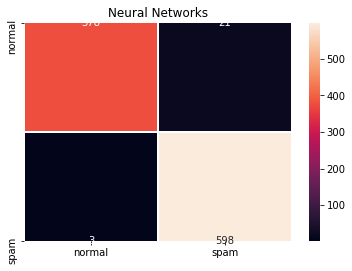

In [50]:
plot_heatmap(results_cm['neural_networks'],'Neural Networks')

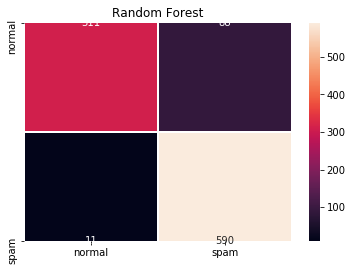

In [51]:
plot_heatmap(results_cm['random_forest'],'Random Forest')